In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def find_files(folder_path):
    """
    Recursively find all files in a folder and its subfolders.
    
    Args:
    - folder_path (str): Path to the folder to search.
    
    Returns:
    - file_paths (list): List of paths to all files found.
    """
    file_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths

In [3]:
#find all files in RIPS/Original/ folder
files = find_files("databases/RIPS/Original")
print("Found", len(files), "files.")

#create a dataframe which contains the file paths
df = pd.DataFrame(files, columns=["file_path"])
#replace all backslashes with forward slashes
df['file_path'] = df['file_path'].apply(lambda x: x.replace("\\", "/"))
#add a column for the patient ID
df['patient_id'] = df['file_path'].apply(lambda x: x.split("/")[-4].split(".")[0])


Found 120 files.


In [31]:
#groub by patient ID and count the number of files for each patient, add the count as a new column
df_count = df.groupby("patient_id").count().reset_index()
df_count_n_rows = len(df_count.index)
print("Found", df_count_n_rows, "unique patients.")
print(df["patient_id"].value_counts().head(10))

Found 4 unique patients.
patient_id
subject1    30
subject2    30
subject3    30
subject4    30
Name: count, dtype: int64


In [5]:
df_count.head()

,patient_id,file_path
0,subject1,30
1,subject2,30
2,subject3,30
3,subject4,30


In [6]:
train_portion = 0.7
test_portion = 0.1
validation_portion = 0.2
#find the closest number of files to the train portion
train_count = int(train_portion * len(files))
test_count = int(test_portion * len(files))
validation_count = int(validation_portion * len(files))

all_counts = np.array([train_count, test_count, validation_count])
#create a dataframe with all possible patient ID combinations
df_combinations = pd.DataFrame(columns=["patient_id", "train", "test", "validation"])


In [7]:
#normalize the counts in df_count
df_count["weight"] = df_count["file_path"] / df_count["file_path"].sum()
#sort the dataframe by the weight
df_count = df_count.sort_values("weight", ascending=False)

df_count.head()

def assign_patients(file_counts, ideal_partition_counts):
    #sort the ideal partition counts in descending order
    ideal_partition_counts = sorted(ideal_partition_counts, reverse=True)
    dynamic_counts = [0 for _ in range(len(ideal_partition_counts))]
    #sort the file counts in descending order
    file_counts = sorted(file_counts, reverse=True)
    partitions = [f'partition_{i}' for i in range(len(ideal_partition_counts))]
    #check if there is an empty partition
    df_assigned = pd.DataFrame(columns=["count", *partitions])
    while len(file_counts) > 0:
        #calculate the difference between the ideal partition counts and the current partition counts
        diff = np.array(ideal_partition_counts) - np.array(dynamic_counts)
        
        #find the index of the partition with the largest difference
        partition_index = np.argmax(diff)
        #check if there are empty partitions
        if min(dynamic_counts) == 0:
            partition_index = np.argmin(dynamic_counts)
        
        #find the index of the patient with the largest count
        count_index = np.argmax(file_counts)
        #assign the patient to the partition with the largest difference
        dynamic_counts[partition_index] += file_counts[count_index]
        print(dynamic_counts)
        #add the patient to the partition as a new row
        zero_list = [0 for _ in range(len(partitions))]
        df_assigned.loc[len(df_assigned.index)] = [file_counts[count_index], *zero_list ]
        df_assigned.loc[len(df_assigned.index)-1, partitions[partition_index]] = 1
        #remove the count from the list
        file_counts.pop(count_index)
    #print(dynamic_counts)
    print(diff)
    return df_assigned



In [36]:
#pass the data to the partitioning function
print(all_counts)
df_assigned = assign_patients(list(df_count["file_path"]), all_counts)
df_assigned.groupby('count').sum().reset_index().values


[84 12 24]
[30, 0, 0]
[30, 30, 0]
[30, 30, 30]
[60, 30, 30]
[ 54  -6 -18]


array([[30,  2,  1,  1]], dtype=int64)

In [9]:
from data_pipeline.data_loading import DfDataset
from torch.utils.data import ConcatDataset, Dataset, DataLoader
import torch
import pydicom
from PIL import Image

In [10]:
class DICOMDataset(Dataset):
    def __init__(self, data_df, labels, transform=None):
        self.data_df = data_df
        self.transform = transform
        self.labels = labels
    def __len__(self):
        return len(self.data_df)
    def __getitem__(self, idx):
        file_path = self.data_df[idx]
        img_array = pydicom.dcmread(file_path).pixel_array
        img = Image.fromarray(img_array).convert('RGB')
        if self.transform:
            img = self.transform(img)
        #convert image to tensor
        img = torch.Tensor(img).float()
        label = torch.Tensor(self.labels[idx]).float()
        return img, label

In [11]:
import json

In [12]:
#import resizer
import torchvision.transforms as transforms
resizer = transforms.Resize((224, 224))
to_tensor = transforms.ToTensor()
all_transforms = transforms.Compose([resizer, to_tensor])

In [13]:
#create a DfDataset
open_data_df = pd.read_csv(filepath_or_buffer='datasets/2024-02-23-13-31-39/All_train.csv')
#read the json file
with open('datasets/2024-02-23-13-31-39/dataset_config.json') as f:
    dataset_config = json.load(f)
#load the dataset
dataset = DfDataset(df=open_data_df, label_cols=dataset_config['label_names'], data_path_col='path_to_img', transform=resizer)


In [14]:
from pydicom.dataset import FileDataset

def dicom_detect_pixels(dcm_file :FileDataset) -> bool:
    try:
        dcm_file.pixel_array
        return True
    except:
        return False


In [15]:
#read in labels
labels = pd.read_excel('D:\ird_project\IRD-Dataset-Complete-03-anonymized.xlsx')['Diagnose'].values
diagnosis_df = pd.read_excel('D:\ird_project\IRD-Dataset-Complete-03-anonymized.xlsx')
keys = diagnosis_df['Index'].values
contain_cfp = np.array([True if x == 'True' else False for x in diagnosis_df['CFP'].values])


In [16]:
#covert to boolean list
#filter out the files that do not contain pixel data
keys_labels = np.stack((keys, labels, contain_cfp), axis=1)
print(keys_labels[0])
keys_labels_with_cfp = keys_labels[keys_labels[:, 2] == True]
keys_with_cfp = keys_labels_with_cfp[:, 0]
labels_with_cfp = keys_labels_with_cfp[:, 1]
#strip the labels of leading and trailing whitespaces
#convert to numpy
print(len(keys_with_cfp), len(labels_with_cfp))

[1 'Morbus Stargardt' True]
663 663


In [19]:
def match_key_label(key, label, data_storage_path : str):
    file_paths = find_files(f'{data_storage_path}/{key}')
    matched_data = [[file_path, label] for file_path in file_paths]
    return np.array(matched_data)

def match_keys_labels(keys, labels, data_storage_path : str):
    matched_data = []
    for key, label in zip(keys, labels):
        matched_data.extend(match_key_label(key, label, data_storage_path))
    return np.array(matched_data)


In [20]:
#match the labels with the file paths
data_storage_path = 'D:/ird_project/export_heyex_original_dataset_03/DICOM'
formatted_keys = np.vectorize(lambda x: str(x).zfill(4))(keys_with_cfp)
matched_data = match_keys_labels(keys=formatted_keys, labels=labels_with_cfp, data_storage_path=data_storage_path)


In [21]:
#clean the data
matched_data_has_pixels = np.vectorize(lambda x: dicom_detect_pixels(pydicom.dcmread(x)))(matched_data[:, 0])

In [22]:
print(len(matched_data[:, 0]))

2141


In [23]:
matched_data_with_pixels = matched_data[matched_data_has_pixels]
print("Found", len(matched_data_with_pixels), "clean data labels.")

Found 2111 clean data labels.


In [24]:
important_labels = ['Best Disease', 'Stargardt Disease', 'Retinitis Pigmentosa']
matched_labels = np.array(matched_data)
renamed_labels = np.vectorize(lambda x: 'Retinitis Pigmentosa' if x == 'Retinitis pigmentosa' else x)(matched_data_with_pixels[:, 1])
renamed_labels = np.vectorize(lambda x: 'Stargardt Disease' if x == 'Morbus Stargardt' else x)(renamed_labels)
renamed_labels = np.vectorize(lambda x: 'Best Disease' if x == 'Morbus Best' else x)(renamed_labels)
#replace the labels with the important labels
matched_data_with_pixels[:, 1] = renamed_labels
#filter out the labels that are not important
matched_data_with_pixels = matched_data_with_pixels[np.isin(matched_data_with_pixels[:, 1], important_labels)]

In [25]:
print("Found", len(matched_data_with_pixels), "important labels.")
#import one hot encoder
from sklearn.preprocessing import OneHotEncoder
#initialize the encoder
#fit the encoder to the labels
all_categories = [dataset_config['label_names']]
encoder = OneHotEncoder(categories = all_categories, sparse=False)
#transform the labels
labels_transformed = encoder.fit_transform(matched_data_with_pixels[:, 1].reshape(-1, 1))
print(encoder.categories_)
#todo implement that the label order is kept

Found 1051 important labels.
[array(['Age-related Macular Degeneration', 'Best Disease',
       'Bietti crystalline dystrophy', 'cataract',
       'Cone Dystrophie or Cone-rod Dystrophie', 'Diabetic Retinopathy',
       'glaucoma', 'Maculopathy', 'Myopia', 'Normal',
       'Retinitis Pigmentosa', 'Stargardt Disease'], dtype=object)]


c:\Users\elyes\miniconda3\envs\ird_deep_learning\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [26]:
print(labels_transformed)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [27]:
print(matched_data_with_pixels[0][0])

D:/ird_project/export_heyex_original_dataset_03/DICOM/0001\100062\506240\9020098\00000000


In [28]:
#generate DICOMDataset
dcm_dataset = DICOMDataset(data_df=matched_data_with_pixels[:,0], labels=labels_transformed, transform=all_transforms)

torch.Size([3, 224, 224])


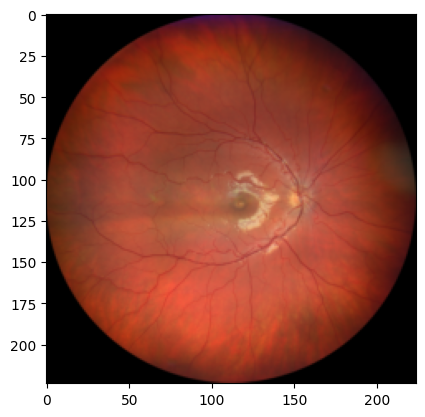

In [29]:
#plot the first image
img, label = dcm_dataset[0]
print(img.shape)
plt.imshow(img.permute(1, 2, 0))

In [30]:
#concatenate the datasets
full_dataset = ConcatDataset([dataset, dcm_dataset])
#create a dataloader
dataloader = DataLoader(full_dataset, batch_size=128, shuffle=True)
#create a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#simple model
import torch.nn as nn
import torch.nn.functional as F
model = nn.Sequential(
    nn.MaxPool2d(8),
    nn.Conv2d(3, 1, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    #flatten the tensor
    nn.Flatten(),
    nn.Linear(169, 3),

)
#move the model to the device
model.to(device)
#iterate over the dataloader
for i, (imgs, labels) in enumerate(dataloader):
    #move the images and labels to the device
    imgs, labels = imgs.to(device), labels.to(device)
    #forward pass
    output = model(imgs)
print('completed training')
    

completed training
